In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
filter_size1 = 5
num_filters1 = 16

fiter_size2 = 5
num_filters2 = 36

fc_size = 128

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("MNIST_data", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
data.test.cls = np.argmax(data.test.labels, axis = 1)

In [5]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size,img_size)
num_channels = 1
num_classes = 10

In [6]:
def plot_images(images, cls_true, cls_pred = None):
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #showing true predicted class
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

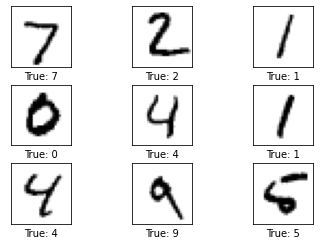

In [7]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images = images, cls_true = cls_true)

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))


In [9]:
#Tensorflow graph for character recognition
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    bias = new_biases(length = num_filters)
    
    layer = tf.nn.conv2d(input = input, filter = weights, strides = [1,1,1,1], padding = "SAME")
    layer += bias
    
    if use_pooling:
        layer = tf.nn.max_pool(value = layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = "SAME")
    
    layer = tf.nn.relu(layer)
    return layer, weights

In [10]:
#converting the 4 dimensional tensor to 2 dimensional tensor
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    num_features = np.array(layer_shape[1:4], dtype = int).prod()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

In [11]:
#function for a fully connected layer
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [12]:
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape = [None, 10], name = 'y_true')
y_true_cls = tf.argmax(y_true, dimension = 1)

Instructions for updating:
Use the `axis` argument instead


In [13]:
#convolution layer 1
layer_conv1, weights_conv1 = new_conv_layer(input = x_image, num_input_channels = num_channels, 
                                          filter_size = filter_size1,
                                          num_filters = num_filters1, 
                                          use_pooling = True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [14]:
#convolution layer 2
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1, num_input_channels = num_filters1,
                                           filter_size = num_filters2,
                                           num_filters = num_filters2,
                                           use_pooling = True)

layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [15]:
#flatten layer
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [16]:
num_features

1764

In [17]:
#fully connected layer 1
layer_fc1 = new_fc_layer(input = layer_flat, num_inputs = num_features,
                        num_outputs = fc_size,
                        use_relu = True)
layer_fc1


<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [18]:
#fully connected layer 2
layer_fc2 = new_fc_layer(input = layer_fc1, num_inputs = fc_size,
                        num_outputs = num_classes,
                        use_relu = False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [19]:
# Predicted Class
y_pred = tf.nn. softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension = 1)


In [20]:
#Cost function to be optimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = layer_fc2, labels = y_true)
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

In [22]:
#Performance Measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
# Tensorflow run
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [24]:
train_batch_size = 64

total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        sess.run(optimizer, feed_dict_train)
        
        if (i%100 == 0):
            acc = sess.run(accuracy, feed_dict = feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, training_accuracy: {1:>6.1%}"
            print(msg.format(i+1, acc))
    end_time = time.time()
    
    time_diff = end_time-start_time
    print("Time usage: "+ str(timedelta(seconds=int(round(time_diff)))))

In [25]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)
    print(cm)
    
    plt.matshow(cm)

In [26]:
def plot_confusion_matrix(cls_pred):
    cls_true  = data.test.cls
    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)
    print(cm)
    plt.matshow()
    plt.colorbar()
    tick_marks = np.arrange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [27]:
#showing performance
test_batch_size = 256
def print_test_accuracy(show_example_errors = False,
                       show_confusion_matrix = False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype = np.int)
    i = 0
    while(i< num_test):
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict = feed_dict)
        i = j
        print(i)

    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    print(correct_sum)
    
    acc = float(correct_sum)/ num_test
    msg = "Accuracy on Test-Set: {0:.1%}({1}/{2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if(show_example_errors):
        print("Example errors: ")
        plot_example_errors(cls_pred = cls_pred, correct = correct)
    
    if(show_confusion_matrix):
        print("Confusion Matrix: ")
        plot_confusion_matrix(cls_pred = cls_pred)

In [28]:
# Performance before optimization
print_test_accuracy()

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
6144
6400
6656
6912
7168
7424
7680
7936
8192
8448
8704
8960
9216
9472
9728
9984
10000
373
Accuracy on Test-Set: 3.7%(373/10000)


In [29]:
optimize(num_iterations = 1)

Optimization Iteration:      1, training_accuracy:   6.2%
Time usage: 0:00:03


In [30]:
print_test_accuracy()

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
6144
6400
6656
6912
7168
7424
7680
7936
8192
8448
8704
8960
9216
9472
9728
9984
10000
702
Accuracy on Test-Set: 7.0%(702/10000)


In [31]:
optimize(num_iterations = 99)

Optimization Iteration:      1, training_accuracy:  10.9%


KeyboardInterrupt: 

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations = 900)

In [ ]:
print_test_accuracy()